In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
import os
from tslearn.clustering import TimeSeriesKMeans

/home/mbikandi/miniconda3/envs/ssstsc/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [8]:
class UCI_HARDataset(Dataset):

    def __init__(self,
            dataset_dir: str = None,
            split: str = "train",
            wsize: int = 10,
            wstride: int = 1
            ) -> None:
        super().__init__()

        '''
            UCI-HAR dataset handler

            Inputs:
                dataset_dir: Directory of the prepare_har_dataset.py
                    processed dataset.
                wsize: window size
                wstride: window stride
        '''

        self.wsize = wsize
        self.wstride = wstride

        # load dataset
        files = filter(
            lambda x: "sensor.npy" in x,
            os.listdir(os.path.join(dataset_dir, "UCI HAR Dataset", split)))
        
        splits = [0]

        STS = []
        SCS = []
        for f in files:
            sensor_data = np.load(os.path.join(dataset_dir, "UCI HAR Dataset", split, f))
            STS.append(sensor_data)
            SCS.append(np.load(os.path.join(dataset_dir, "UCI HAR Dataset", split, f.replace("sensor", "class"))))

            splits.append(sensor_data.shape[0])

        splits = np.array(splits[:-1])

        self.STS = np.concatenate(STS)
        self.SCS = np.concatenate(SCS)

        self.indices = np.arange(self.SCS.shape[0])
        for i in range(wsize * wstride):
            self.indices[splits + i] = 0
        self.indices = self.indices[np.nonzero(self.indices)]

    def __len__(self):
        return self.indices.shape[0]
    
    def __getitem__(self, index: int) -> tuple[np.ndarray, np.ndarray]:

        first = self.indices[index]-self.wsize*self.wstride
        last = self.indices[index]

        return self.STS[first:last:self.wstride,:], self.SCS[first:last:self.wstride]
    
    def slice(self, indexes: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        assert len(indexes.shape) == 1 # only accept 1-dimensional arrays

        return_sts = np.empty((indexes.shape[0], self.wsize, self.STS.shape[-1]))
        return_scs = np.empty((indexes.shape[0], self.wsize))

        for i, id in enumerate(indexes):
            ts, c = self[id]
            return_scs[i] = c
            return_sts[i] = ts

        return return_sts, return_scs
    
    def getWindowsIndex(self):

        id = []
        cl = []
        for i in self.indices:
            if np.unique(self.SCS[(i-self.wsize*self.wstride):i]).shape[0] == 1:
                id.append(i)
                cl.append(self.SCS[i])
        
        return np.array(id), np.array(cl)

In [9]:
ds = UCI_HARDataset("../storage/datasets/UCI-HAR/", split="train", wsize=64)

In [10]:
wid, wcl = ds.getWindowsIndex()

In [178]:
def obtain_barycenter(dataset, window_id, window_lb, n_random=100):
    
    np.random.seed(0)

    selected = np.empty((np.unique(window_lb).shape[0], dataset.wsize, dataset.STS.shape[-1]))

    for i, c in enumerate(np.unique(window_lb)):
        # get the random windows for the class c

        rw = np.random.choice(window_id[window_lb == c].reshape(-1), n_random)

        ts, cs = dataset.slice(rw)

        km = TimeSeriesKMeans(n_clusters=1, verbose=True, random_state=1, metric="dtw")
        km.fit(ts)

        selected[i] = km.cluster_centers_[0]
    
    return selected

In [105]:
obtain_barycenter(ds, )

In [127]:
a = np.concatenate([np.expand_dims(w[i], 0) for i in np.random.choice(np.argwhere(l == 2).reshape(-1), 200)])

In [128]:
km = TimeSeriesKMeans(n_clusters=1, verbose=True, random_state=1, metric="dtw")
km.fit(a)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


72.604 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


47.049 --> 47.049 --> 47.049 --> 


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


TimeSeriesKMeans(metric='dtw', n_clusters=1, random_state=1, verbose=True)

In [61]:
import matplotlib.pyplot as plt

[[<matplotlib.lines.Line2D at 0x7f56b9146200>],

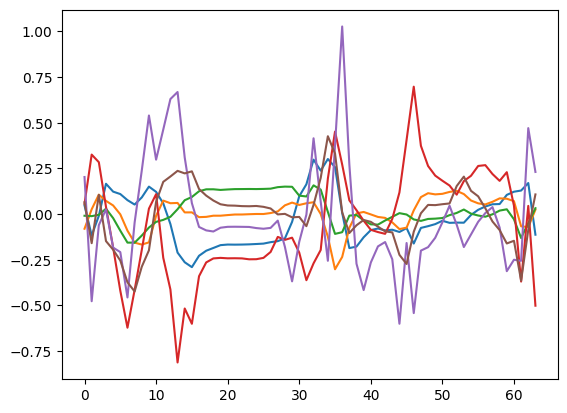

In [123]:
fig, ax = plt.subplots(nrows=1)
[ax.plot(km.cluster_centers_[0,:,d]) for d in range(6)]

[[<matplotlib.lines.Line2D at 0x7f56b91edff0>],

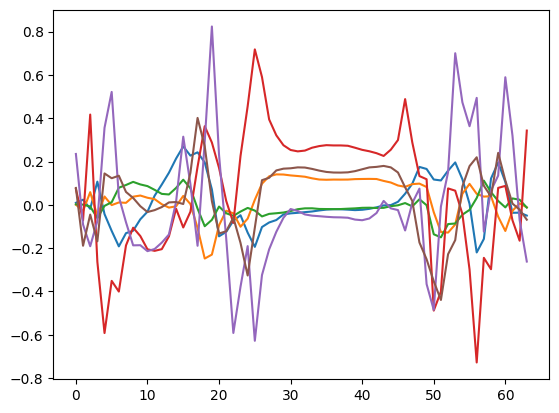

In [126]:
fig, ax = plt.subplots(nrows=1)
[ax.plot(km.cluster_centers_[0,:,d]) for d in range(6)]

[[<matplotlib.lines.Line2D at 0x7f56b91827d0>],

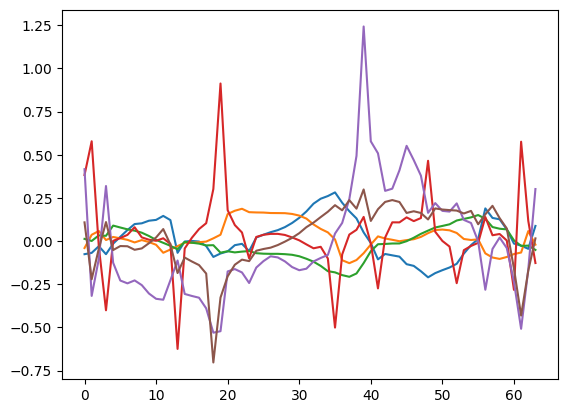

In [129]:
fig, ax = plt.subplots(nrows=1)
[ax.plot(km.cluster_centers_[0,:,d]) for d in range(6)]